# Task

Operators like joins, selections and missing value imputaters can cause *data distribution issues*, which can heavily impact the performance of our model. Mlinspect helps with identifying such issues by offering an inspection to calculate historams for sensitive groups. Thanks to our annotation propagation, this works even if the group columns are projected out at some point. To automatically check for significant changes and compute the histograms, we used the `no_bias_introduced_for(...)` constraint.

We want to find out if preprocessing operations in this pipeline introduce bias and if so, which groups are effected.
The pipeline we want to analyse can be found using the path `os.path.join(str(get_project_root()), "example_pipelines", "compas", "compas.py")`. Its code:

> ```python
> """
> An example pipeline
> """
> import os
> 
> import pandas as pd
> from sklearn.compose import ColumnTransformer
> from sklearn.impute import SimpleImputer
> from sklearn.linear_model import LogisticRegression
> from sklearn.pipeline import Pipeline
> from sklearn.preprocessing import OneHotEncoder, KBinsDiscretizer, label_binarize
> 
> from mlinspect.utils import get_project_root
> 
> train_file = os.path.join(str(get_project_root()), "example_pipelines", "compas", "compas_train.csv")
> train_data = pd.read_csv(train_file, na_values='?', index_col=0)
> test_file = os.path.join(str(get_project_root()), "example_pipelines", "compas", "compas_test.csv")
> test_data = pd.read_csv(test_file, na_values='?', index_col=0)
> 
> train_data = train_data[
>     ['sex', 'dob', 'age', 'c_charge_degree', 'race', 'score_text', 'priors_count', 'days_b_screening_arrest',
>      'decile_score', 'is_recid', 'two_year_recid', 'c_jail_in', 'c_jail_out']]
> test_data = test_data[
>     ['sex', 'dob', 'age', 'c_charge_degree', 'race', 'score_text', 'priors_count', 'days_b_screening_arrest',
>      'decile_score', 'is_recid', 'two_year_recid', 'c_jail_in', 'c_jail_out']]
> 
> train_data = train_data[(train_data['days_b_screening_arrest'] <= 30) & (train_data['days_b_screening_arrest'] >= -30)]
> train_data = train_data[train_data['is_recid'] != -1]
> train_data = train_data[train_data['c_charge_degree'] != "O"]
> train_data = train_data[train_data['score_text'] != 'N/A']
> 
> train_data = train_data.replace('Medium', "Low")
> test_data = test_data.replace('Medium', "Low")
> 
> train_labels = label_binarize(train_data['score_text'], classes=['High', 'Low'])
> test_labels = label_binarize(test_data['score_text'], classes=['High', 'Low'])
> 
> impute1_and_onehot = Pipeline([('imputer1', SimpleImputer(strategy='most_frequent')),
>                                ('onehot', OneHotEncoder(handle_unknown='ignore'))])
> impute2_and_bin = Pipeline([('imputer2', SimpleImputer(strategy='mean')),
>                             ('discretizer', KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='uniform'))])
> 
> featurizer = ColumnTransformer(transformers=[
>     ('impute1_and_onehot', impute1_and_onehot, ['is_recid']),
>     ('impute2_and_bin', impute2_and_bin, ['age'])
> ])
> 
> pipeline = Pipeline([
>     ('features', featurizer),
>     ('classifier', LogisticRegression())
> ])
> 
> pipeline.fit(train_data, train_labels.ravel())
> print(pipeline.score(test_data, test_labels.ravel()))
> 
> ```

The COMPAS dataset contains information about 6,889 criminal defendants in Broward County, FL, along with pre- dictions of their recidivism risk, as produced by a commercial tool called COMPAS. The sensitive attributes include gender and race. The task is to predict whether a defendant is likely re-offend. 

# Step 1/4: Add check and execute the pipeline

The central entry point of mlinspect is the `PipelineInspector`. To use mlinspect, we use it and pass it the path to the runnable version of the example pipeline. Here, we have the example pipeline in a `.py` file. 

First, we define the check we want mlinspect to run. In this example, we only use 1 check to compute histograms of sensitive groups and verify operators cause no significant distribution changes.

Then, we execute the pipeline. Mlinspect returns a `InspectorResult`, which contains the output of our check. 

In [1]:
import os
from mlinspect.utils import get_project_root

from mlinspect import PipelineInspector
from mlinspect.checks import NoBiasIntroducedFor

HEALTHCARE_FILE_PY = os.path.join(str(get_project_root()), "example_pipelines", "compas", "compas.py")

inspector_result = PipelineInspector\
    .on_pipeline_from_py_file(HEALTHCARE_FILE_PY) \
    .add_check(NoBiasIntroducedFor(['sex', 'race'])) \
    .execute()

check_results = inspector_result.check_to_check_results

0.8078521939953811


# Step 2/4: Overview of the check results
## Did our check find issues?

Let us look at the `check_result` to see whether some checks failed. We see that some issue was found, so we have to investigate it.

In [2]:
from IPython.display import display
import pandas as pd
pd.set_option('display.max_colwidth', None)

check_result_df = PipelineInspector.check_results_as_data_frame(check_results)
display(check_result_df)

,check_name,status,description
0,"NoBiasIntroducedFor((('sex', 'race'), -0.3))",CheckStatus.FAILURE,"A Selection causes a min_relative_ratio_change of 'race' by -0.33167874516032964, a value below the configured minimum threshold -0.3!"


# Step 3/4: List of operations that could change the distribution 

As stated before, only some operations like selections, joins and missing value imputation can change the distribution. Our check already filtered all operators that can cause data distribution issues. Now we will use the result to create list with all distribution changes and visualize them. Using this, we can investigate the changes of the different operators one at a time.

In [3]:
no_bias_check_result = check_results[NoBiasIntroducedFor(['sex', 'race'])]

distribution_changes_overview_df = NoBiasIntroducedFor.get_distribution_changes_overview_as_df(no_bias_check_result)
display(distribution_changes_overview_df)

dag_node_distribution_changes_list = list(no_bias_check_result.bias_distribution_change.items())

,DagNode OperatorType,DagNode CodeReference,DagNode Module,DagNode Description,'sex' distribution change below the configured minimum test threshold,'race' distribution change below the configured minimum test threshold
0,OperatorType.SELECTION,"CodeReference(lineno=27, col_offset=13, end_lineno=27, end_col_offset=119)","(pandas.core.frame, __getitem__, Selection)",Select by series (indirectly using 'days_b_screening_arrest'),False,True
1,OperatorType.SELECTION,"CodeReference(lineno=28, col_offset=13, end_lineno=28, end_col_offset=53)","(pandas.core.frame, __getitem__, Selection)",Select by series (indirectly using 'is_recid'),False,False
2,OperatorType.SELECTION,"CodeReference(lineno=29, col_offset=13, end_lineno=29, end_col_offset=61)","(pandas.core.frame, __getitem__, Selection)",Select by series (indirectly using 'c_charge_degree'),False,False
3,OperatorType.SELECTION,"CodeReference(lineno=30, col_offset=13, end_lineno=30, end_col_offset=58)","(pandas.core.frame, __getitem__, Selection)",Select by series (indirectly using 'score_text'),False,False


# Step 4/4 Detailed Investigation

We start by looking at the first operator that could heavily change the proportion of groups in our data, the `.dropna()` selection. Then, ...

 OperatorType.SELECTION CodeReference(lineno=27, col_offset=13, end_lineno=27, end_col_offset=119) ('pandas.core.frame', '__getitem__', 'Selection') Select by series (indirectly using 'days_b_screening_arrest') 

 Column 'sex', acceptable change: True, min_relative_ratio_change: -0.00526926631466584


,sensitive_column_value,count_before,count_after,ratio_before,ratio_after,relative_ratio_change
0,Female,970,825,0.192117,0.191105,-0.005269
1,Male,4079,3492,0.807883,0.808895,0.001253


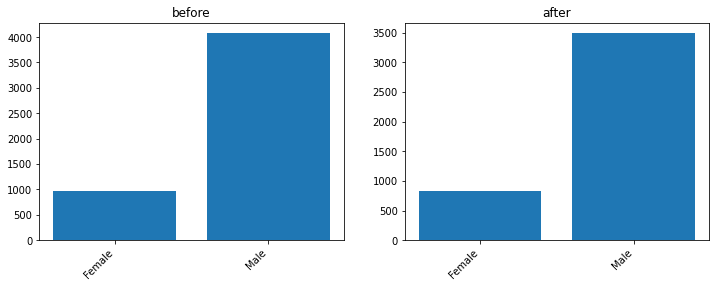


 Column 'race', acceptable change: False, min_relative_ratio_change: -0.33167874516032964


,sensitive_column_value,count_before,count_after,ratio_before,ratio_after,relative_ratio_change
0,African-American,2588,2228,0.512577,0.516099,0.006872
1,Asian,23,22,0.004555,0.005096,0.118712
2,Caucasian,1707,1462,0.338087,0.338661,0.001699
3,Hispanic,452,357,0.089523,0.082696,-0.076253
4,Native American,14,8,0.002773,0.001853,-0.331679
5,Other,265,240,0.052486,0.055594,0.059226


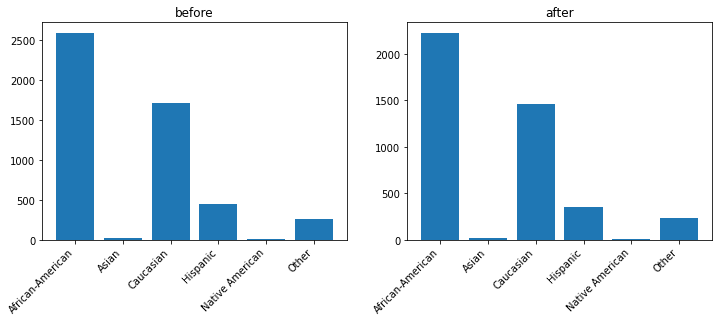

In [4]:
# Select the DagNode we want to look at by index
selection, selection_distribution_changes = dag_node_distribution_changes_list[0]

# Investige the changes
print('\033[1m', selection.operator_type, selection.code_reference, selection.module, selection.description, '\033[0m')
for column, distribution_change in selection_distribution_changes.items():
    print("")
    print("\033[1m Column '{}'\033[0m, acceptable change: {}, min_relative_ratio_change: {}".format(column, distribution_change.acceptable_change, distribution_change.min_relative_ratio_change))
    display(distribution_change.before_and_after_df)
    NoBiasIntroducedFor.plot_distribution_change_histograms(distribution_change)

**As we can see, there are no noteworthy changes because of the join.**

**The `most-frequent` imputation amplifies the existing `race` imbalance!**

# Your answer: Did we find operators that introduce bias? How much did the distribution change?

**TODO:** ... We conclude, ...